In [ ]:
# Installs
!pip install pandas prophet spacy matplotlib requests nltk
!python -m spacy download en_core_web_sm

import nltk
nltk.download('wordnet')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Imports and Setup
import os
import re
import time
import zipfile
import requests
import pandas as pd
import numpy as np
import nltk
# from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter, defaultdict
import spacy
import matplotlib.pyplot as plt
from prophet import Prophet
import logging


def download_nltk_resource(resource_id, resource_name_for_print):
    """Checks for NLTK resource and downloads if missing. Corrected version."""
    try:
        nltk.data.find(resource_id)
        print(f"NLTK resource '{resource_name_for_print}' found.")
    except LookupError:
        print(f"NLTK resource '{resource_name_for_print}' not found. Attempting download...")
        try:

            nltk.download(resource_name_for_print, quiet=False)

            try:

                 dl_dir = nltk.downloader.Downloader().default_download_dir()
                 if os.path.exists(os.path.join(dl_dir, resource_id)):
                     print(f"Download attempted for '{resource_name_for_print}'. Package likely present now.")
                 elif os.path.exists(os.path.join(dl_dir, resource_name_for_print + ".zip")):
                     print(f"Download attempted for '{resource_name_for_print}'. Zip file present.")
                 else:

                      raise LookupError(f"Verification check suggests '{resource_name_for_print}' download might have failed despite no download error.")

            except Exception as verify_e:

                 print(f"Warning: Could not fully verify download status for '{resource_name_for_print}' after attempt. Error: {verify_e}")


        except Exception as e:
             print(f"ERROR: Failed to download '{resource_name_for_print}'. Error: {e}")
             print(f"Please check internet connection or run nltk.download('{resource_name_for_print}') manually in Python.")



             global USE_LEMMATIZATION
             # --- END ADDED global ---

             if resource_name_for_print == 'wordnet' and USE_LEMMATIZATION:
                  print("Wordnet is required for lemmatization. Please ensure it downloads successfully to proceed.")

                  raise RuntimeError("Wordnet download failed, cannot proceed with lemmatization.")
# --- Run NLTK Checks ---
print("Checking NLTK resources...")
download_nltk_resource('corpora/stopwords', 'stopwords')
download_nltk_resource('tokenizers/punkt', 'punkt')
download_nltk_resource('taggers/averaged_perceptron_tagger', 'averaged_perceptron_tagger')
download_nltk_resource('corpora/wordnet', 'wordnet') # Needed for lemmatizer if used
print("NLTK resource check complete.")

# --- Load spaCy Model ---
disabled_pipes = []

try:
    nlp = spacy.load("en_core_web_sm", disable=disabled_pipes)
    if disabled_pipes:
        print(f"Loaded spaCy model with pipes disabled: {disabled_pipes}")
    else:
        print("Loaded default spaCy model.")
except OSError:
    print("spaCy model 'en_core_web_sm' not found.")
    print("Please ensure it was downloaded correctly in the first cell using:")
    print("!python -m spacy download en_core_web_sm")
    # Raise error to stop execution if spaCy model failed loading
    raise RuntimeError("spaCy model 'en_core_web_sm' failed to load.")

# --- Prepare Stopwords ---
ENGLISH_STOPWORDS = set(stopwords.words('english'))

print("Setup Complete.")

Checking NLTK resources...
NLTK resource 'stopwords' not found. Attempting download...
Download attempted for 'stopwords'. Package likely present now.
NLTK resource 'punkt' not found. Attempting download...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Download attempted for 'punkt'. Package likely present now.
NLTK resource 'averaged_perceptron_tagger' not found. Attempting download...
Download attempted for 'averaged_perceptron_tagger'. Package likely present now.
NLTK resource 'wordnet' not found. Attempting download...
NLTK resource check complete.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded default spaCy model.
Setup Complete.


In [ ]:
# Cell 3: Configuration

# --- Paths ---

script_dir = '.'
CORPUS_DIR_PROCESSED = os.path.join(script_dir, 'corpus_processed')
ZIPPED_CORPUS_PATH = os.path.join(script_dir, 'corpus_processed.zip')

# --- Data Sources ---
WIKI_TOPICS = [
    "Natural language processing", "Machine learning", "Artificial intelligence",
    "Linguistics", "Computational linguistics", "Language model", "Neural networks",
    "Speech recognition", "Text mining", "Deep learning", "Semantic search",
    "Grammar", "Syntax", "Morphology (linguistics)", "Etymology", "Lexicography",
    "Language acquisition", "Translation", "Corpus linguistics", "Phonetics",
    "Pragmatics", "Sentiment analysis", "Discourse analysis", "Word embeddings",
    "Transformer model", "Large language models", "Speech synthesis", "Named entity recognition",
    # "Statistical NLP", "Multilingual NLP", # Removed due to previous 404 errors
    "Text classification", "Speech-to-text", "ChatGPT", "BERT",
    "Cultural linguistics", "Psycholinguistics"
]
GUTENBERG_BOOK_IDS = [
    "84", "1661", "11", "98", "1342", "2701", "2600", "1080", "345", "43",
    "2852", "174", "30254", "5200", "1232", "100", "3200", "1400",
    "10893", "768", "236"
]

# --- Preprocessing Options ---

USE_LEMMATIZATION = True
REMOVE_STOPWORDS = True
MIN_WORD_LENGTH = 3 # Minimum length for a word to be considered

# --- Analysis Options ---
WORDS_TO_ANALYZE = ["intelligence", "machine", "soul", "love"] # Example words
FREQUENCY_NORMALIZATION_BASE = 10000
POS_ANALYSIS_ENABLED = True

# --- Prediction Options ---
PREDICTION_ENABLED = True
FUTURE_YEARS_TO_PREDICT = 10
PROPHET_INTERVAL_WIDTH = 0.90


BUILD_NEW_CORPUS_IF_EXISTS = False

print("Configuration set.")

Configuration set.


In [ ]:
#Class Definitions

class CorpusManager:
    """Handles fetching, processing, and saving corpus data."""
    def __init__(self, raw_dir, processed_dir, zip_path):

        self.processed_dir = processed_dir
        self.zip_path = zip_path
        self.book_years = self._get_book_years()

        try:
             os.makedirs(self.processed_dir, exist_ok=True)
        except OSError as e:
             print(f"ERROR: Could not create directory {self.processed_dir}. Check permissions. {e}")
             # Raise error to stop execution if directory cannot be created
             raise RuntimeError(f"Failed to create corpus directory: {self.processed_dir}") from e


    def _get_book_years(self):
        # Central place for book year mapping
        return {
            "84": 1818, "1661": 1892, "11": 1865, "98": 1859, "1342": 1813,
            "2701": 1851, "2600": 1869, "1080": 1729, "345": 1897, "43": 1886,
            "2852": 1850, "174": 1890, "30254": 1845, "5200": 1915, "1232": 1922,
            "100": 1320, "3200": -380, "1400": 1860, "10893": 1000, "768": 180,
            "236": 1894
        }
    def _preprocess_text(self, text, use_lemma=USE_LEMMATIZATION, remove_stops=REMOVE_STOPWORDS):
        """Basic text cleaning and optional lemmatization/stopword removal. Includes dynamic nlp.max_length increase AND truncation."""
        global nlp
        if not text:
            return "", []

        # --- ADD TRUNCATION ---
        ABSOLUTE_MAX_CHARS = 2000000
        original_length = len(text)
        if original_length > ABSOLUTE_MAX_CHARS:
            print(f"Info: Truncating text from {original_length} to {ABSOLUTE_MAX_CHARS} characters before processing.")
            text = text[:ABSOLUTE_MAX_CHARS]



        required_length = len(text)
        if required_length >= nlp.max_length:
            new_max_length = required_length + 100
            print(f"Info: Text length ({required_length}) exceeds spaCy's max_length ({nlp.max_length}). Increasing limit to {new_max_length}.")
            try:
                 nlp.max_length = new_max_length
            except Exception as e:
                 print(f"ERROR: Failed to increase nlp.max_length. {e}")
                 print("Processing might fail for this text.")
                 return "", []


        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()

        try:
            doc = nlp(text)
        except ValueError as e:
             print(f"ERROR: spaCy processing failed for text (length {required_length}). Error: {e}")
             return "", []

        tokens = []
        for token in doc:
            if token.is_alpha and len(token.text) >= MIN_WORD_LENGTH:
                if remove_stops and token.text in ENGLISH_STOPWORDS:
                    continue
                if use_lemma:
                     lemma = token.lemma_
                else:
                     lemma = token.text
                tokens.append(lemma)

        processed_text = ' '.join(tokens)
        return processed_text, tokens

    def fetch_wikipedia(self, topics):
        print("Fetching Wikipedia articles...")
        current_year = time.localtime().tm_year

        for topic in topics:
            safe_topic_name = re.sub(r'[\\/*?:"<>|]', "-", topic.replace(' ', '_'))
            file_name = f"wiki_{safe_topic_name}_{current_year}.txt"
            save_path = os.path.join(self.processed_dir, file_name)

            if not BUILD_NEW_CORPUS_IF_EXISTS and os.path.exists(save_path):
                 print(f"  Skipping '{topic}' - file already exists.")
                 continue

            url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{topic}"
            print(f"  Fetching '{topic}'...")
            try:
                response = requests.get(url, timeout=10)
                response.raise_for_status()
                data = response.json()
                extract = data.get("extract", "")
                processed_text, _ = self._preprocess_text(extract)
                if processed_text:
                    with open(save_path, "w", encoding="utf-8") as f:
                        f.write(processed_text)
                else:
                     print(f"  Warning: No processable text found for Wikipedia topic '{topic}'.")
            except requests.exceptions.RequestException as e:
                print(f"  Error fetching Wikipedia topic '{topic}': {e}")
            time.sleep(0.5)

    def fetch_gutenberg(self, book_ids):
        print("Fetching Gutenberg books...")
        for book_id in book_ids:
            year = self.book_years.get(book_id)
            if year is None:
                print(f"Warning: Skipping Gutenberg ID {book_id} - no year defined.")
                continue

            file_name = f"gutenberg_{book_id}_{year}.txt"
            save_path = os.path.join(self.processed_dir, file_name)

            if not BUILD_NEW_CORPUS_IF_EXISTS and os.path.exists(save_path):
                 print(f"  Skipping Book ID {book_id} - file already exists.")
                 continue

            url = f"https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt"
            print(f"  Fetching Book ID {book_id} (Year {year})...")
            try:
                response = requests.get(url, timeout=30)
                response.raise_for_status()
                text = response.content.decode('utf-8', errors='ignore')

                print(f"  Processing Book ID {book_id} (Length: {len(text)} chars)...")
                start_process_time = time.time()
                processed_text, _ = self._preprocess_text(text)
                end_process_time = time.time()
                print(f"  Finished processing Book ID {book_id} in {end_process_time - start_process_time:.2f} seconds.")

                if processed_text:
                    with open(save_path, "w", encoding="utf-8") as f:
                        f.write(processed_text)
                else:
                    print(f"  Warning: No processable text resulted for Gutenberg ID {book_id} after processing attempt.")
            except requests.exceptions.RequestException as e:
                print(f"  Error fetching Gutenberg ID {book_id}: {e}")
            time.sleep(0.5)

    def build_corpus(self, wiki_topics, gutenberg_ids):
        """Fetches all data and saves processed files."""
        print(f"Building corpus in directory: {self.processed_dir}")
        self.fetch_wikipedia(wiki_topics)
        self.fetch_gutenberg(gutenberg_ids)
        print("Corpus fetching complete.")

    def zip_corpus(self):
        """Zips the processed corpus directory."""
        if not os.path.isdir(self.processed_dir):
             print(f"Error: Processed directory not found: {self.processed_dir}. Skipping zip.")
             return

        processed_files = [f for f in os.listdir(self.processed_dir) if f.endswith('.txt')]
        if not processed_files:
            print("Processed corpus directory is empty. Skipping zip.")
            return

        print(f"Zipping corpus to {self.zip_path}...")
        try:
            with zipfile.ZipFile(self.zip_path, 'w', zipfile.ZIP_DEFLATED) as zip_obj:
                for filename in processed_files:
                    file_path = os.path.join(self.processed_dir, filename)
                    zip_obj.write(file_path, arcname=filename)
            print("Corpus zipping complete.")
        except Exception as e:
            print(f"Error zipping corpus: {e}")


    def load_corpus_data(self):
        """Loads processed text data into a dictionary keyed by year."""
        print("Loading corpus data for analysis...")
        corpus_data = defaultdict(list)

        if not os.path.isdir(self.processed_dir):
             print(f"ERROR: Processed corpus directory not found: {self.processed_dir}")
             return {}

        filenames = [f for f in os.listdir(self.processed_dir) if f.endswith('.txt')]

        if not filenames:
             print(f"Warning: No .txt files found in the processed corpus directory: {self.processed_dir}")
             return {}

        for file_name in filenames:
            match = re.search(r'_(-?\d{1,4})\.txt$', file_name)
            if match:
                try:
                   year = int(match.group(1))
                   file_path = os.path.join(self.processed_dir, file_name)
                   with open(file_path, 'r', encoding='utf-8') as file:
                       content = file.read()
                       if content:
                          corpus_data[year].append(content)
                except ValueError:
                    print(f"Warning: Could not parse year from extracted string '{match.group(1)}' in filename '{file_name}'. Skipping.")
                except Exception as e:
                    print(f"Error reading file {file_name}: {e}")

        if not corpus_data:
             print("Warning: No data loaded after processing files.")
             return {}

        print(f"Loaded data for {len(corpus_data)} years.")
        return dict(sorted(corpus_data.items()))


class TrendAnalyzer:
    """Analyzes word trends (frequency, POS) from loaded corpus data."""
    def __init__(self, corpus_data):
        if not corpus_data:
            print("Warning: TrendAnalyzer initialized with no corpus data.")
            self.corpus_data = {}
            self.yearly_word_counts = {}
        else:
            self.corpus_data = corpus_data
            self.yearly_word_counts = self._calculate_yearly_counts()

    def _calculate_yearly_counts(self):
        """Pre-calculates word counts and total words per year."""
        print("Pre-calculating word counts per year...")
        yearly_counts = {}
        if not self.corpus_data: return yearly_counts

        for year, texts in self.corpus_data.items():
            year_tokens = []
            for text in texts:
                year_tokens.extend(text.split())

            total_words = len(year_tokens)
            if total_words > 0:
                yearly_counts[year] = {
                    'counts': Counter(year_tokens),
                    'total_words': total_words
                }
            else:
                yearly_counts[year] = {'counts': Counter(), 'total_words': 0}
        print("Word count calculation complete.")
        return yearly_counts

    def analyze_frequency(self, word):
        """Analyzes normalized frequency evolution for a word."""
        word = word.lower()
        word_trend = {}

        if not self.yearly_word_counts:
             print("Warning: Word counts not available for frequency analysis.")
             return word_trend

        for year, data in self.yearly_word_counts.items():
            count = data['counts'].get(word, 0)
            total_words = data['total_words']
            normalized_freq = (count / total_words) * FREQUENCY_NORMALIZATION_BASE if total_words > 0 else 0
            word_trend[year] = normalized_freq

        return word_trend

    def analyze_pos(self, word):
        """Analyzes POS tag distribution evolution for a word."""
        global nlp # Reference global nlp object which might have updated max_length
        word = word.lower()
        pos_trend = defaultdict(Counter)

        if not self.corpus_data:
            print("Warning: Corpus data not available for POS analysis.")
            return {}

        print(f"Analyzing POS for '{word}'...")
        start_pos_time = time.time()
        for year, texts in self.corpus_data.items():
             year_pos_counts = Counter()
             word_found_in_year = False
             texts_containing_word = [t for t in texts if re.search(r'\b' + re.escape(word) + r'\b', t)]
             if not texts_containing_word: continue

             print(f"  Processing POS for year {year} ({len(texts_containing_word)} relevant texts)...", end='\r') # Use end='\r' for progress update
             for text in texts_containing_word:
                 try:

                     required_length = len(text)
                     if required_length >= nlp.max_length:
                         nlp.max_length = required_length + 100

                     doc = nlp(text)
                     for token in doc:
                         token_match = token.lemma_.lower() if USE_LEMMATIZATION else token.text.lower()
                         if token_match == word:
                             year_pos_counts[token.pos_] += 1
                             word_found_in_year = True
                 except ValueError as e:
                      print(f"\n  Warning: spaCy error during POS analysis for year {year}. Error: {e}")
                      continue

             if word_found_in_year:
                pos_trend[year].update(year_pos_counts)
        print(f"\nPOS analysis for '{word}' complete in {time.time() - start_pos_time:.2f} seconds.") # Newline after progress updates
        return {year: dict(counts) for year, counts in sorted(pos_trend.items())}


    def plot_frequency_trend(self, word, word_trend, ax=None):
        """Plots the frequency trend."""
        if not word_trend: return

        standalone_plot = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))
            standalone_plot = True

        years = list(word_trend.keys())
        frequencies = list(word_trend.values())

        ax.plot(years, frequencies, marker='o', linestyle='-', label=f"{word}")
        ax.set_xlabel("Year")
        ax.set_ylabel(f"Freq. per {FREQUENCY_NORMALIZATION_BASE} words")
        ax.grid(True, alpha=0.5)
        ax.legend(fontsize='small')

        if standalone_plot:
             ax.set_title(f"Normalized Frequency Evolution for '{word}'")
             plt.tight_layout()


    def plot_pos_trend(self, word, pos_trend, ax=None):
        """Plots the POS distribution trend using a stacked area chart."""
        if not pos_trend: return

        standalone_plot = False
        if ax is None:
             fig, ax = plt.subplots(figsize=(12, 6))
             standalone_plot = True

        years = list(pos_trend.keys())
        valid_years = [yr for yr in years if isinstance(pos_trend[yr], dict) and sum(pos_trend[yr].values()) > 0]
        if not valid_years: return

        all_pos_tags = sorted({pos for yr in valid_years for pos in pos_trend[yr]})
        if not all_pos_tags: return

        data_stacked = {pos: [pos_trend[yr].get(pos, 0) for yr in valid_years] for pos in all_pos_tags}
        total_counts_per_year = [sum(data_stacked[pos][i] for pos in all_pos_tags) for i in range(len(valid_years))]
        data_percent = {
             pos: [(count / total) * 100 if total > 0 else 0 for count, total in zip(counts, total_counts_per_year)]
             for pos, counts in data_stacked.items()
        }

        bottom = np.zeros(len(valid_years))
        num_tags = len(all_pos_tags)

        cmap_name = 'tab20' if num_tags <= 20 else 'viridis'
        try:
            cmap = plt.colormaps[cmap_name]
            colors = cmap(np.linspace(0, 1, num_tags))
        except KeyError:
             cmap = plt.colormaps['viridis']
             colors = cmap(np.linspace(0, 1, num_tags))


        for i, (pos, percentages) in enumerate(data_percent.items()):
            percentages = np.array(percentages)
            ax.fill_between(valid_years, bottom, bottom + percentages, label=pos, color=colors[i], alpha=0.8)
            bottom += percentages

        ax.set_xlabel("Year")
        ax.set_ylabel("Percentage (%)")
        ax.set_ylim(0, 100)
        ax.grid(True, alpha=0.5)
        ax.legend(title="POS Tags", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

        if standalone_plot:
             ax.set_title(f"POS Tag Distribution Evolution for '{word}' (% of occurrences)")
             plt.tight_layout()
             # plt.show() # Show is handled globally in main


class TrendPredictor:
    """Predicts future trends using Prophet."""
    def __init__(self, history_df):
        """history_df: Pandas DataFrame with 'ds' (datetime) and 'y' (value) columns."""
        if not isinstance(history_df, pd.DataFrame) or history_df.empty or 'ds' not in history_df or 'y' not in history_df:
             print("Warning: Invalid or empty history DataFrame provided to TrendPredictor.")
             self.history_df = pd.DataFrame({'ds':[], 'y':[]})
             self.model = None
             return

        if len(history_df) < 2:
             print(f"Warning: Insufficient data for Prophet initialization ({len(history_df)} rows < 2).")
             self.history_df = history_df
             self.model = None
             return

        try:
            df_copy = history_df.copy()
            df_copy['ds'] = pd.to_datetime(df_copy['ds'])
            self.history_df = df_copy.sort_values('ds')
            self.model = Prophet(interval_width=PROPHET_INTERVAL_WIDTH)
        except Exception as e:
            print(f"Error processing history DataFrame: {e}")
            self.history_df = pd.DataFrame({'ds':[], 'y':[]})
            self.model = None


    def train(self):
        """Trains the Prophet model."""
        if self.model is None: return False
        if self.history_df.empty or len(self.history_df) < 2: return False

        try:
            print("Training Prophet model...")
            start_train_time = time.time()


            self.model.fit(self.history_df)



            print(f"Prophet training complete in {time.time() - start_train_time:.2f} seconds.")
            return True
        except Exception as e:
            print(f"Error training Prophet model: {e}")
            self.model = None
            return False


    def predict(self, future_periods, freq='YS'):
        """Makes future predictions."""
        if self.model is None: return None
        if future_periods <= 0: return None

        try:
            print(f"Making future predictions for {future_periods} periods...")
            future_df = self.model.make_future_dataframe(periods=future_periods, freq=freq)
            forecast = self.model.predict(future_df)
            print("Prediction complete.")
            # Ensure yhat and intervals are non-negative
            forecast['yhat'] = forecast['yhat'].clip(lower=0)
            forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
            forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
            return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        except Exception as e:
            print(f"Error during Prophet prediction: {e}")
            return None

    def plot_forecast(self, forecast, ax=None):
        """Plots the Prophet forecast."""
        if self.model is None or forecast is None: return

        standalone_plot = False
        if ax is None:
            fig_prophet = plt.figure(figsize=(12, 6))
            ax = fig_prophet.add_subplot(111)
            standalone_plot = True

        try:
             fig_prophet_internal = self.model.plot(forecast, ax=ax)
             ax.set_title("Frequency Forecast")
             ax.set_xlabel("Year")
             ax.set_ylabel("Predicted Norm. Frequency")
             if ax.get_legend() is not None: ax.get_legend().remove()
        except Exception as e: print(f"Error plotting Prophet forecast: {e}")

        if standalone_plot:
             plt.tight_layout()
             # plt.show() # Show handled globally

    def predict_future_pos_distribution(self, historical_pos_trend, predicted_frequencies_df):
        """Predicts future POS distribution based on recent historical ratios."""
        print("Predicting future POS distribution based on recent ratios...")
        if not historical_pos_trend: return {}

        recent_years = sorted([yr for yr, counts in historical_pos_trend.items() if isinstance(counts, dict) and sum(counts.values()) > 0])[-10:]
        if not recent_years: return {}

        aggregated_pos_counts = Counter()
        for year in recent_years:
            if isinstance(historical_pos_trend.get(year), (Counter, dict)):
                 aggregated_pos_counts.update(historical_pos_trend[year])

        total_recent_count = sum(aggregated_pos_counts.values())
        if total_recent_count == 0: return {}

        pos_ratios = {pos: count / total_recent_count for pos, count in aggregated_pos_counts.items()}

        future_pos_predictions = {}
        if predicted_frequencies_df is None or predicted_frequencies_df.empty: return {}

        for _, row in predicted_frequencies_df.iterrows():
            try: year = row['ds'].year
            except AttributeError: continue

            predicted_freq_raw = max(0, row['yhat'])
            year_pos_dist = {}
            total_dist_val = 0
            for pos, ratio in pos_ratios.items():
                 dist_val = predicted_freq_raw * ratio
                 year_pos_dist[pos] = dist_val
                 total_dist_val += dist_val

            if total_dist_val > 1e-9 and predicted_freq_raw > 1e-9:
                try:
                     renorm_factor = predicted_freq_raw / total_dist_val
                     for pos in year_pos_dist: year_pos_dist[pos] *= renorm_factor
                except ZeroDivisionError: pass

            future_pos_predictions[year] = year_pos_dist

        print("POS distribution prediction complete.")
        return future_pos_predictions

    def plot_predicted_pos(self, predicted_pos_trend, ax=None):
        """Plots the predicted POS distribution."""
        if not predicted_pos_trend: return

        standalone_plot = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))
            standalone_plot = True

        years = sorted(predicted_pos_trend.keys())
        all_pos_tags = sorted({pos for year_data in predicted_pos_trend.values() for pos in year_data})
        if not all_pos_tags: return

        data_stacked = {pos: [predicted_pos_trend[year].get(pos, 0) for year in years] for pos in all_pos_tags}
        total_vals_per_year = [sum(data_stacked[pos][i] for pos in all_pos_tags) for i in range(len(years))]
        data_percent = {
             pos: [(val / total) * 100 if total > 1e-9 else 0 for val, total in zip(counts, total_vals_per_year)]
             for pos, counts in data_stacked.items()
        }

        bottom = np.zeros(len(years))
        num_tags = len(all_pos_tags)
        cmap_name = 'tab20' if num_tags <= 20 else 'viridis'
        try:
            cmap = plt.colormaps[cmap_name]
            colors = cmap(np.linspace(0, 1, num_tags))
        except KeyError:
            cmap = plt.colormaps['viridis']
            colors = cmap(np.linspace(0, 1, num_tags))

        for i, (pos, percentages) in enumerate(data_percent.items()):
            percentages = np.array(percentages)
            ax.fill_between(years, bottom, bottom + percentages, label=pos, color=colors[i], alpha=0.8)
            bottom += percentages

        ax.set_title("Predicted POS Distribution")
        ax.set_xlabel("Year")
        ax.set_ylabel("Predicted %")
        ax.set_ylim(0, 100)
        ax.grid(True, alpha=0.5)
        ax.legend(title="POS Tags", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

        if standalone_plot:
             plt.tight_layout()



print("Class definitions complete.")

Class definitions complete.


In [ ]:
# main Function Definition

def main():
    print("Starting Language Trend Analysis...")
    overall_start_time = time.time()


    corpus_manager = CorpusManager(None, CORPUS_DIR_PROCESSED, ZIPPED_CORPUS_PATH)


    processed_dir_exists = os.path.isdir(CORPUS_DIR_PROCESSED)
    processed_files_exist = processed_dir_exists and len(os.listdir(CORPUS_DIR_PROCESSED)) > 0


    build_new = BUILD_NEW_CORPUS_IF_EXISTS or not processed_files_exist

    if build_new:
        print(f"Building new corpus (Forced: {BUILD_NEW_CORPUS_IF_EXISTS}, Dir Missing/Empty: {not processed_files_exist})...")
        corpus_manager.build_corpus(WIKI_TOPICS, GUTENBERG_BOOK_IDS)

    else:
        print(f"Using existing corpus data in {CORPUS_DIR_PROCESSED}")


    corpus_data = corpus_manager.load_corpus_data()
    if not corpus_data:
        print("No corpus data loaded. Exiting.")
        return


    print("\n--- Analyzing Historical Trends ---")
    analyzer = TrendAnalyzer(corpus_data)

    if not WORDS_TO_ANALYZE:
        print("No words specified in WORDS_TO_ANALYZE. Exiting.")
        return
    num_words = len(WORDS_TO_ANALYZE)

    # Create subplots for historical trends dynamically
    num_hist_cols = 2 if POS_ANALYSIS_ENABLED else 1
    fig_hist, axes_hist = plt.subplots(num_words, num_hist_cols,
                                       figsize=(8 * num_hist_cols, 4 * num_words),
                                       squeeze=False, sharex=True)

    historical_trends = {}

    for i, word in enumerate(WORDS_TO_ANALYZE):
        print(f"\nAnalyzing word: '{word}'")
        word_start_time = time.time()

        # Analyze Frequency
        freq_trend = analyzer.analyze_frequency(word)
        historical_trends[word] = {'frequency': freq_trend}
        analyzer.plot_frequency_trend(word, freq_trend, ax=axes_hist[i, 0])
        axes_hist[i, 0].set_title(f"'{word}' Frequency") # Set specific subplot title

        # Analyze POS Tags
        if POS_ANALYSIS_ENABLED:
            pos_trend = analyzer.analyze_pos(word)
            historical_trends[word]['pos'] = pos_trend
            analyzer.plot_pos_trend(word, pos_trend, ax=axes_hist[i, 1])
            axes_hist[i, 1].set_title(f"'{word}' POS Distribution (%)") # Set specific title

        word_end_time = time.time()
        print(f"Analysis for '{word}' took {word_end_time - word_start_time:.2f} seconds.")

    try:

        fig_hist.tight_layout(rect=[0, 0, 0.85, 1])

    except Exception as e:
        print(f"Error adjusting historical plot layout: {e}")

    try:
        from IPython.display import display
        display(fig_hist)
    except ImportError:
        plt.show(block=False)

    plt.close(fig_hist)

    # 3. Predict Future Trends
    if PREDICTION_ENABLED:
        print("\n--- Predicting Future Trends ---")

        num_pred_cols = 2 if POS_ANALYSIS_ENABLED else 1

        fig_pred, axes_pred = plt.subplots(num_words, num_pred_cols,
                                           figsize=(8 * num_pred_cols, 4 * num_words),
                                           squeeze=False, sharex=True)

        for i, word in enumerate(WORDS_TO_ANALYZE):
             print(f"\nPredicting for word: '{word}'")
             predict_start_time = time.time()

             # Prepare data for Prophet
             freq_trend = historical_trends[word].get('frequency', {})
             if not freq_trend:
                  print(f"Skipping prediction for '{word}': No historical frequency data.")
                  continue


             df_list = []
             valid_years_for_pred = []
             for year, freq in freq_trend.items():

                 if year > 1700 and freq > 1e-9 :
                     try:
                        dt = pd.to_datetime(f'{year}-01-01')
                        df_list.append({'ds': dt, 'y': freq})
                        valid_years_for_pred.append(year)
                     except (ValueError, pd.errors.OutOfBoundsDatetime):
                         print(f"Warning: Skipping year {year} for '{word}' prediction due to datetime conversion issue.")

             if not df_list:
                  print(f"Skipping prediction for '{word}': No valid date points found after filtering.")
                  continue

             df = pd.DataFrame(df_list)
             if len(df) < 2:
                  print(f"Skipping prediction for '{word}': Not enough valid data points ({len(df)} < 2) for Prophet.")
                  continue

             # Initialize and Train Predictor
             predictor = TrendPredictor(df)
             trained_ok = predictor.train()

             if not trained_ok:
                  print(f"Skipping prediction for '{word}': Model training failed.")
                  continue


             periods_to_predict = FUTURE_YEARS_TO_PREDICT
             print(f"Info: Predicting {periods_to_predict} periods starting after last data point.")


             if periods_to_predict <= 0:
                 print(f"Warning: Invalid number of periods to predict: {periods_to_predict}")
                 continue

             forecast = predictor.predict(future_periods=periods_to_predict, freq='YS') # Yearly Start

             if forecast is not None:

                  predictor.plot_forecast(forecast, ax=axes_pred[i, 0])
                  axes_pred[i, 0].set_title(f"'{word}' Frequency Forecast")


                  if POS_ANALYSIS_ENABLED:
                     pos_trend_hist = historical_trends[word].get('pos', {})

                     if not df.empty and 'ds' in df.columns:
                        future_forecast = forecast[forecast['ds'] > df['ds'].max()]
                     else:
                         future_forecast = forecast

                     predicted_pos = predictor.predict_future_pos_distribution(pos_trend_hist, future_forecast)
                     predictor.plot_predicted_pos(predicted_pos, ax=axes_pred[i, 1])
                     axes_pred[i, 1].set_title(f"'{word}' Predicted POS (%)")
             else:
                  print(f"Prediction failed for '{word}'.")

             predict_end_time = time.time()
             print(f"Prediction for '{word}' took {predict_end_time - predict_start_time:.2f} seconds.")

        try:
            fig_pred.tight_layout(rect=[0, 0, 0.85, 1])

            try:
                from IPython.display import display
                display(fig_pred)
            except ImportError:
                plt.show()

            plt.close(fig_pred)
        except Exception as e:
             print(f"Error adjusting prediction plot layout: {e}")

    overall_end_time = time.time()
    print(f"\nAnalysis complete. Total execution time: {overall_end_time - overall_start_time:.2f} seconds.")

print("Main function defined.")

Main function defined.


Starting Language Trend Analysis...
Building new corpus (Forced: False, Dir Missing/Empty: True)...
Building corpus in directory: ./corpus_processed
Fetching Wikipedia articles...
  Fetching 'Natural language processing'...
  Fetching 'Machine learning'...
  Fetching 'Artificial intelligence'...
  Fetching 'Linguistics'...
  Fetching 'Computational linguistics'...
  Fetching 'Language model'...
  Fetching 'Neural networks'...
  Fetching 'Speech recognition'...
  Fetching 'Text mining'...
  Fetching 'Deep learning'...
  Fetching 'Semantic search'...
  Fetching 'Grammar'...
  Fetching 'Syntax'...
  Fetching 'Morphology (linguistics)'...
  Fetching 'Etymology'...
  Fetching 'Lexicography'...
  Fetching 'Language acquisition'...
  Fetching 'Translation'...
  Fetching 'Corpus linguistics'...
  Fetching 'Phonetics'...
  Fetching 'Pragmatics'...
  Fetching 'Sentiment analysis'...
  Fetching 'Discourse analysis'...
  Error fetching Wikipedia topic 'Discourse analysis': 429 Client Error: Too ma

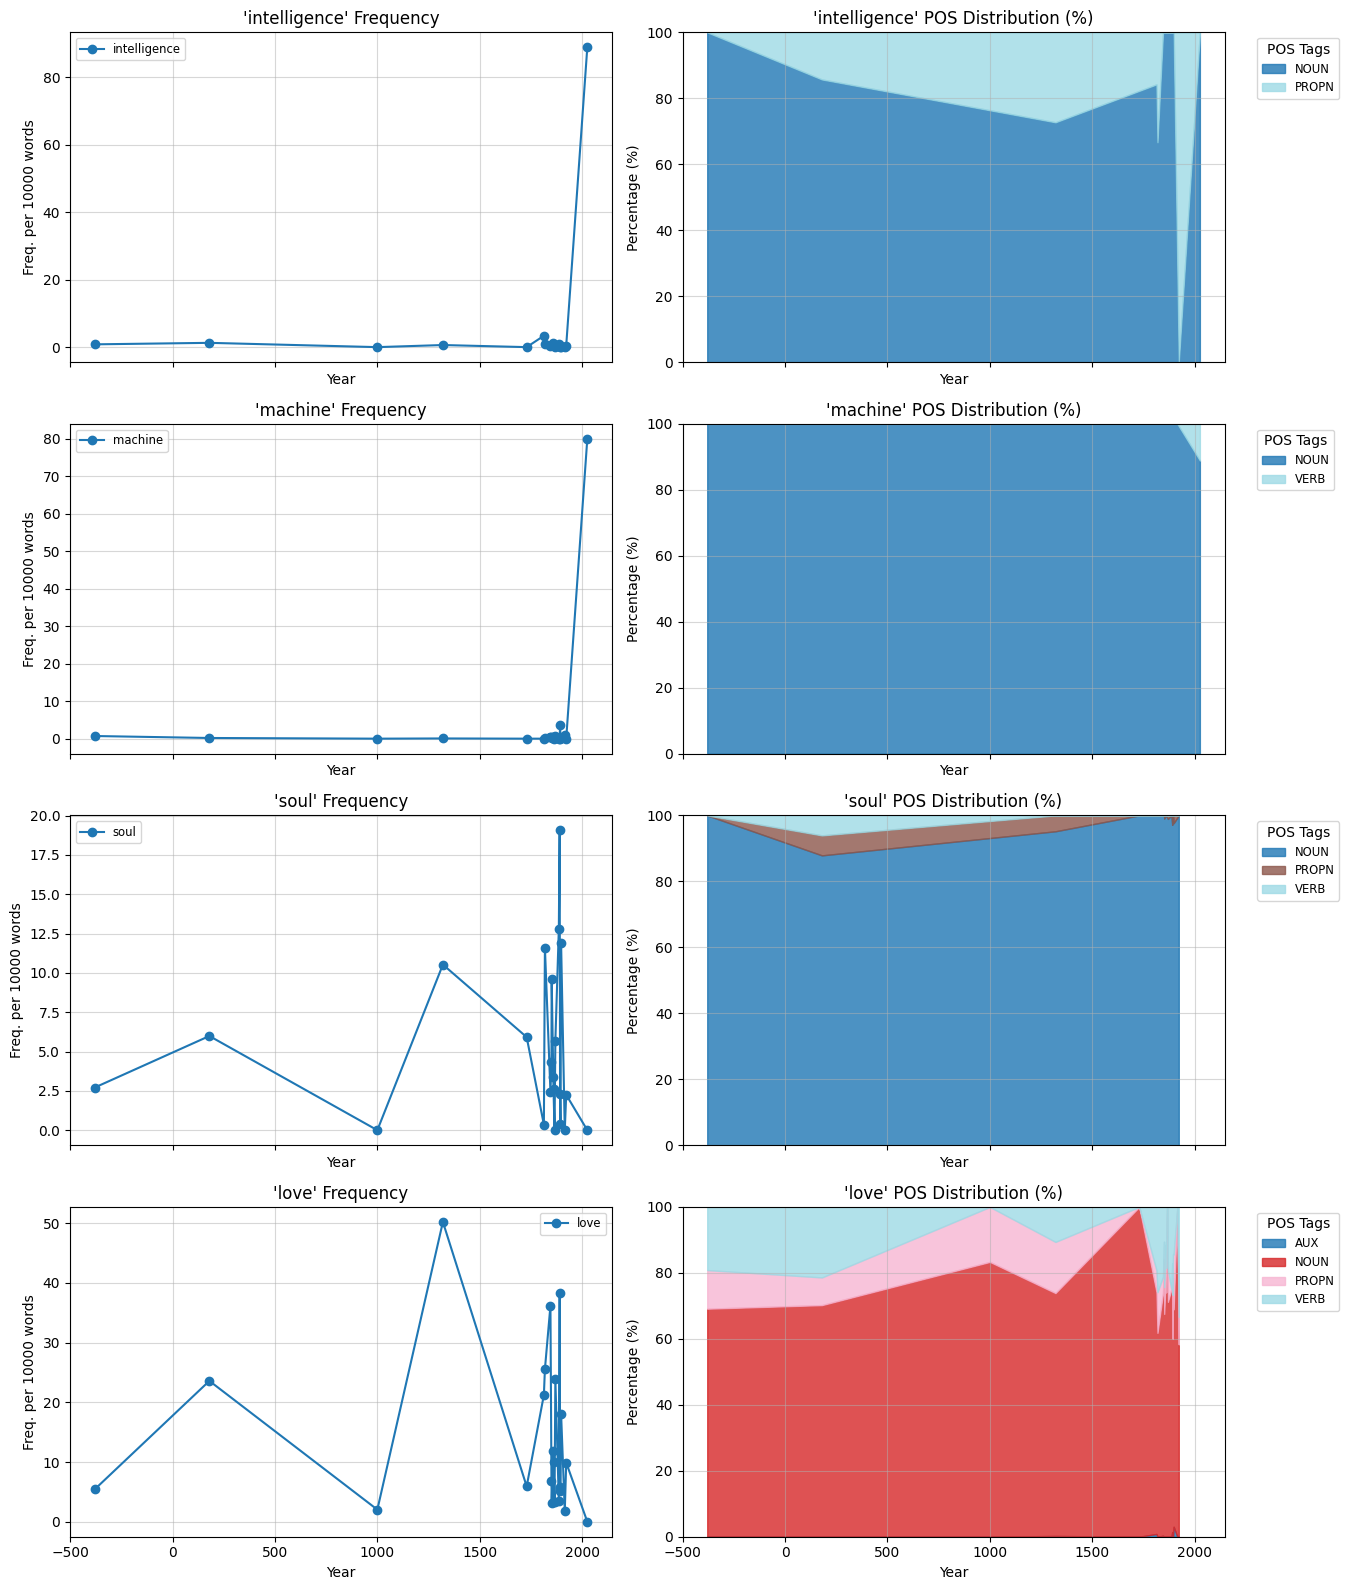


--- Predicting Future Trends ---

Predicting for word: 'intelligence'


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmo_71jpk/l4sj_ofa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmo_71jpk/1zg87c8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20200', 'data', 'file=/tmp/tmpmo_71jpk/l4sj_ofa.json', 'init=/tmp/tmpmo_71jpk/1zg87c8s.json', 'output', 'file=/tmp/tmpmo_71jpk/prophet_model2xo235pv/prophet_model-20250422133008.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:30:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:30:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Training Prophet model...
Prophet training complete in 0.19 seconds.
Info: Predicting 10 periods starting after last data point.
Making future predictions for 10 periods...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmo_71jpk/mmfdnst6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmo_71jpk/qmfb8935.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43902', 'data', 'file=/tmp/tmpmo_71jpk/mmfdnst6.json', 'init=/tmp/tmpmo_71jpk/qmfb8935.json', 'output', 'file=/tmp/tmpmo_71jpk/prophet_model7mjr1kf9/prophet_model-20250422133009.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:30:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:30:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Prediction complete.
Predicting future POS distribution based on recent ratios...
POS distribution prediction complete.
Prediction for 'intelligence' took 0.92 seconds.

Predicting for word: 'machine'
Training Prophet model...
Prophet training complete in 0.09 seconds.
Info: Predicting 10 periods starting after last data point.
Making future predictions for 10 periods...
Prediction complete.
Predicting future POS distribution based on recent ratios...
POS distribution prediction complete.
Prediction for 'machine' took 0.15 seconds.

Predicting for word: 'soul'
Training Prophet model...


13:30:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmo_71jpk/yqc2zal4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmo_71jpk/3kkkftdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59269', 'data', 'file=/tmp/tmpmo_71jpk/yqc2zal4.json', 'init=/tmp/tmpmo_71jpk/3kkkftdq.json', 'output', 'file=/tmp/tmpmo_71jpk/prophet_modelg1ych54f/prophet_model-20250422133009.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:30:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Prophet training complete in 0.10 seconds.
Info: Predicting 10 periods starting after last data point.
Making future predictions for 10 periods...
Prediction complete.
Predicting future POS distribution based on recent ratios...
POS distribution prediction complete.
Prediction for 'soul' took 0.16 seconds.

Predicting for word: 'love'
Training Prophet model...
Prophet training complete in 0.09 seconds.
Info: Predicting 10 periods starting after last data point.
Making future predictions for 10 periods...
Prediction complete.
Predicting future POS distribution based on recent ratios...
POS distribution prediction complete.
Prediction for 'love' took 0.15 seconds.


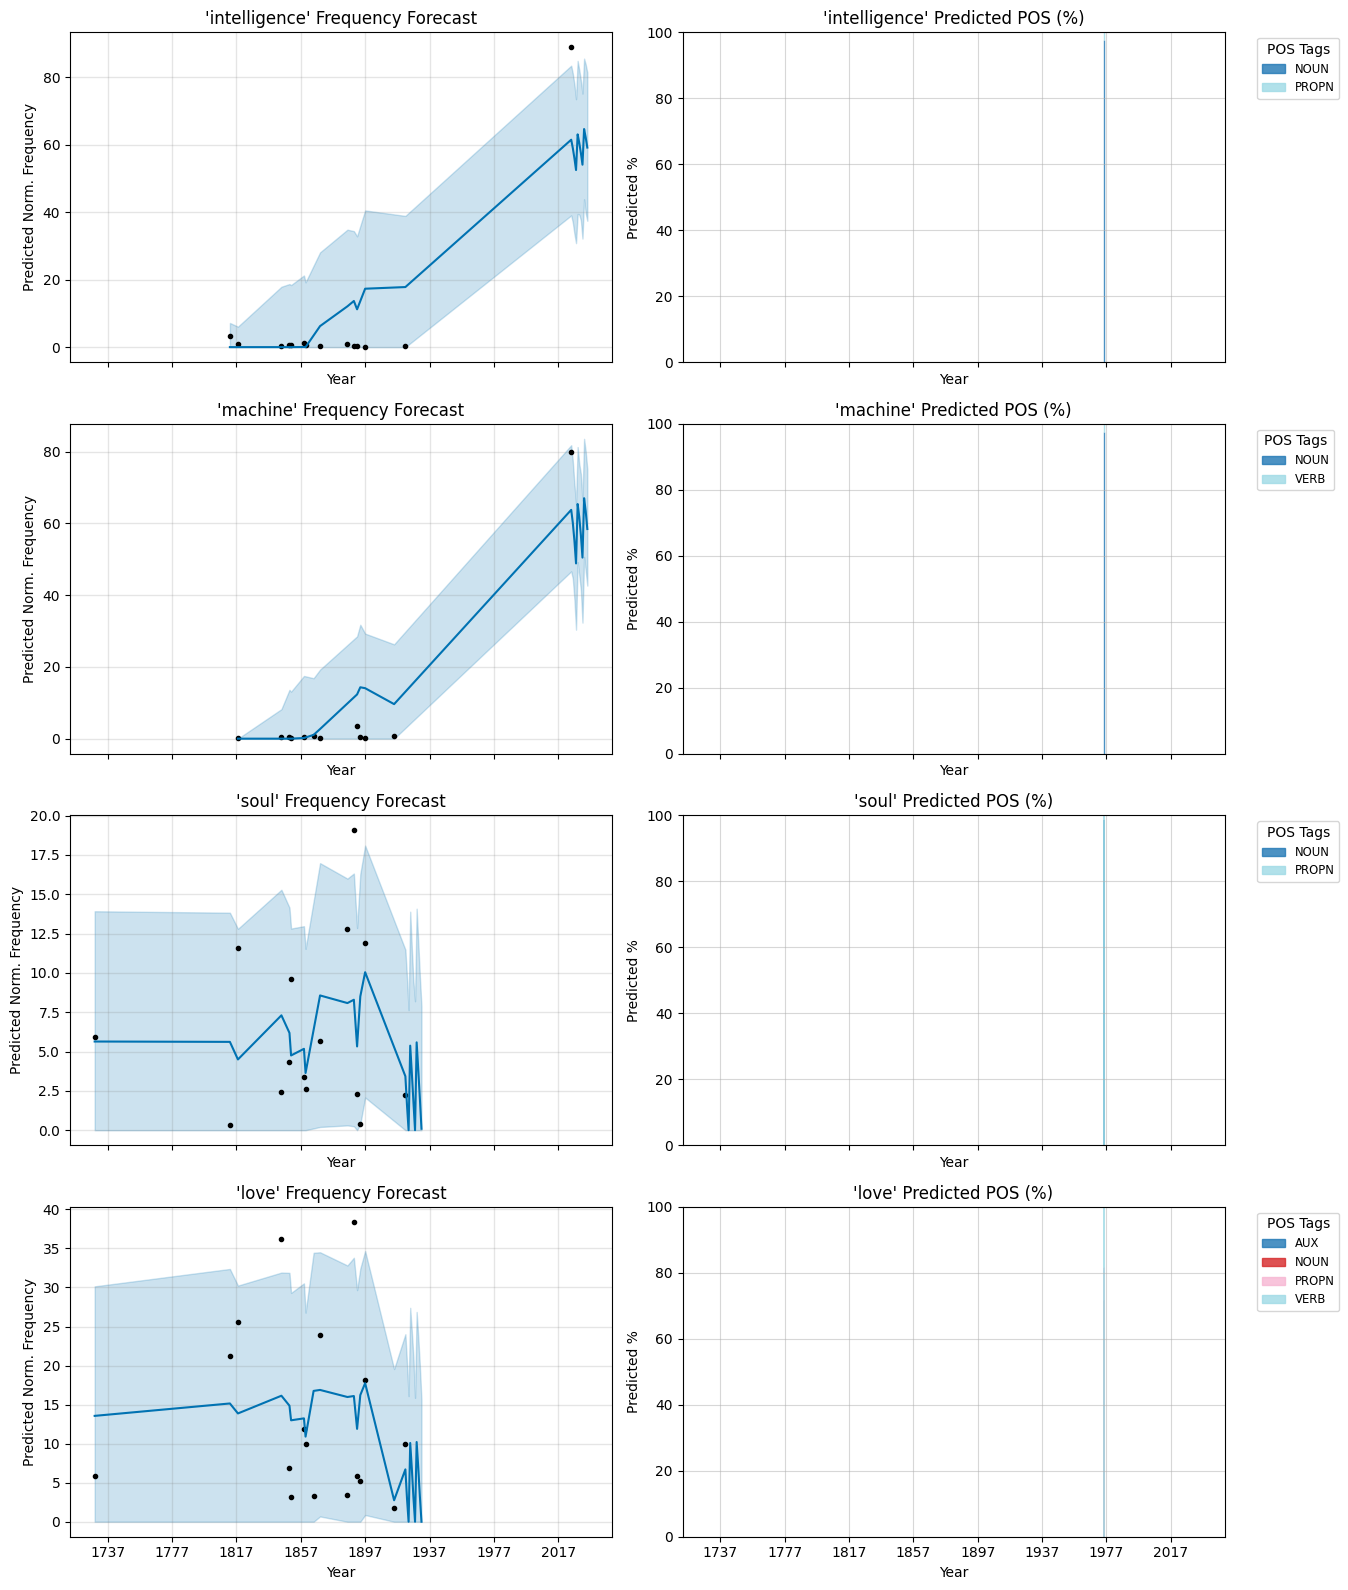


Analysis complete. Total execution time: 1279.52 seconds.


In [ ]:
# Main

if __name__ == "__main__":
    main()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')